In [128]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 27 11:19:07 2020

@author: Max J. de Bock
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import make_interp_spline, BSpline
import numpy.polynomial.polynomial as poly
import statistics as stat
from scipy.signal import find_peaks
from scipy.stats import norm, jarque_bera
from scipy.fft import fft, ifft
from sympy.integrals.transforms import laplace_transform
from scipy.fftpack import fftshift
import scipy as sc
from datetime import datetime

In [121]:
df = pd.DataFrame({'Series': [np.nan], 'Epsilon': [np.nan], 'Sd': [np.nan]}).dropna()
def LoadData():
    SP = pd.read_csv('^GSPC.csv')
    Minute_data =  pd.read_csv('S&P minute data.csv')
    return SP, Minute_data
sp, minute_data = LoadData()
display(minute_data)

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

,Unnamed: 0,A,A.1,A.2,A.3,A.4,AAL,AAL.1,AAL.2,AAL.3,...,ZION,ZION.1,ZION.2,ZION.3,ZION.4,ZTS,ZTS.1,ZTS.2,ZTS.3,ZTS.4
0,NaN,open,high,low,close,volume,open,high,low,close,...,open,high,low,close,volume,open,high,low,close,volume
1,timestamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-11 09:30:00,NaN,NaN,NaN,NaN,NaN,44.01,44.05,44.01,44.01,...,42.05,42.05,42.04,42.04,26933.0,NaN,NaN,NaN,NaN,NaN
3,2017-09-11 09:31:00,65.5,65.5,65.41,65.46,29852.0,44.01,44.25,44.0,44.25,...,42.06,42.54,42.01,42.24,39292.0,65.33,65.39,64.96,65.11,38144.0
4,2017-09-11 09:32:00,65.4604,65.66,65.4604,65.66,3435.0,44.25,44.32,44.22,44.27,...,42.12,42.48,42.09,42.48,9683.0,65.115,65.23,65.075,65.12,4390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43143,2018-02-16 15:55:00,72.095,72.13,72.09,72.125,17309,51.735,51.76,51.735,51.76,...,55.16,55.19,55.16,55.18,11646,79.87,79.94,79.87,79.91,13641
43144,2018-02-16 15:56:00,72.125,72.125,72.07,72.07,15441,51.755,51.78,51.745,51.77,...,55.17,55.19,55.16,55.185,10937,79.901,79.901,79.79,79.8,16029
43145,2018-02-16 15:57:00,72.07,72.1,72.05,72.06,18096,51.77,51.78,51.745,51.75,...,55.185,55.19,55.15,55.15,30957,79.8,79.87,79.79,79.805,23002
43146,2018-02-16 15:58:00,72.06,72.06,72.01,72.01,22146,51.75,51.755,51.7,51.7,...,55.15,55.2,55.14,55.19,46460,79.8,79.805,79.765,79.79,19650


# White noise 

In [30]:
def WhiteNoise(df,mean,sd):
    n = 100
    for i in range(n):
        Xt = np.random.normal(mean,sd)
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-Order Moving Average:

In [31]:
def QthMovAve(df,mean,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 1000
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = mean
        if i != 0:
            for j in range(np.minimum(i,order-1)):    
                 Xt += weights[order-j-1]*df['Epsilon'].iloc[i-j-1]
        df = df.append({'Series': Xt, 'Epsilon': epsilon}, ignore_index=True)
    print(df)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

In [32]:
def SquaredErrorforCycleLength(A,length):
    A = np.array(A)
    var_list = np.zeros(length)
    n = len(A)
    for i in range(length):
        k = 0
        point_list = []
        while k*length <= n-1:
            point_list.append(A[k*length])
            k += 1
        var_list[i] = stat.variance(point_list)
    return stat.mean(var_list)

Thing that tries to find period of periodic function:

In [33]:
def CycleLength(A):
    A = np.array(A)
    SquaredErrors = np.zeros(int(len(A)*2/3))
    for length in range(1,int(len(A)*2/3)):
        SquaredErrors[length] = SquaredErrorforCycleLength(A, length)
    return SquaredErrors

# Qth-Order Auto-regressive:

In [34]:
def QthAR(df,sd,order):
    weights = np.linspace(1,order,order)
    weights = weights/np.sum(weights)
    n = 100
    for i in range(n):
        epsilon = np.random.normal(0,sd)
        Xt = epsilon
        if i != 0:
            for j in range(np.minimum(i,order)):
                Xt += weights[order-j-1]*df['Series'].iloc[i-j-1]
        df = df.append({'Series': Xt}, ignore_index=True)
    plt.scatter(np.linspace(1,n,n),df['Series'])
    return

# Qth-order Auto-regressive conditional heteroskedasticity (ARCH):

In [35]:
def QArch(df,a,order,n):
    #Choosing the weights of the model (assuming weakly-stationary covariance)
    weights = np.linspace(1,order,order)
    weights = (200)**(weights/order)
    weights = weights/np.sum(weights)
    for i in range(n):
        #This is that first term constant
        sd = a
        for j in range(np.minimum(i,order+1)):
            #Summing the products of the weights and squares of previous datapoints
            sd += weights[order-j-1]*df['Series'].iloc[i-j-1]*df['Series'].iloc[i-j-1]
        #Generating next datapoint
        Xt = np.random.normal(0,sd)
        df = df.append({'Series': Xt, 'Sd': sd}, ignore_index=True)
    #Just formatting
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('ARCH(%d)' % order)
    lin = np.linspace(1,n,n)
    ax1.bar(lin,df['Series'])
    ax2.bar(lin,df['Sd'])
    #Getting an approximating poly through it uses Gaussian quadrature,
    #so it is going to be exact up to n/2. This is why I picked n/10.
    #This is really just a randomly chosen number, but line looks 'eye-ball' representative for smoothness = 10 if n = 1000.
    #EDIT: The smoothness of the line will be will change the scale that the red line represents, meaning the period of 
    #the line will be very clearly altered by this!!!
    smoothness = 10
    degree = int(np.ceil(n/smoothness))
    xnew = np.linspace(1,n, n*10) 
    coefs = poly.polyfit(lin, df['Sd'], degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(df['Sd'])
    high = max(df['Sd'])
    plt.ylim([low,high])
    ax3 = ax2.twinx()
    cycle_length = CycleLength(ffit[1::10])
    
    l = len(cycle_length)
    ax3.plot(np.linspace(1,l,l),cycle_length)
    #perform Fourier transform on graph (cutting of edges due to weird behaviour)
    slicing = 50
    ax3.plot(np.linspace(1+int(slicing/10),n-int(slicing/10),n*10-2*slicing),abs(fft(ffit[slicing:len(ffit)-slicing])))
    plt.ylim([0,0.2])
    fig.tight_layout()
    plt.show()
    
    
    return find_peaks(cycle_length, \
                      #threshold = (max(cycle_length)-min(cycle_length))/40),\
                      width = 10),\
           #ChangePlot(df['Series'])

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


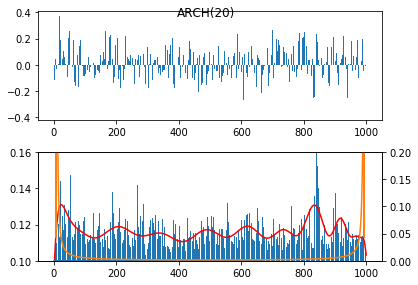

((array([208, 278, 306, 366, 417, 459, 484, 500, 619], dtype=int64),
  {'prominences': array([8.94828323e-05, 1.23836434e-04, 5.74811974e-05, 3.41047317e-05,
          2.05092078e-04, 8.67114333e-05, 5.77176180e-06, 7.45794835e-05,
          1.08893399e-04]),
   'left_bases': array([  0,   0, 293, 332,   0, 440, 476, 440, 440], dtype=int64),
   'right_bases': array([221, 332, 332, 388, 440, 499, 499, 552, 665], dtype=int64),
   'widths': array([10.95043638, 14.2904908 , 11.40880844, 27.36356225, 21.66115796,
          15.53434662, 10.71908861, 21.91743581, 55.9603686 ]),
   'width_heights': array([0.0001183 , 0.00013784, 0.00011451, 0.00011057, 0.00019948,
          0.00015189, 0.00012357, 0.00017822, 0.00020863]),
   'left_ips': array([202.53806195, 270.44734351, 300.36502989, 349.9061075 ,
          405.54697799, 451.2245888 , 479.88190609, 499.65140147,
          590.50093383]),
   'right_ips': array([213.48849833, 284.7378343 , 311.77383833, 377.26966975,
          427.20813596, 46

In [170]:
#To get decent compromise between data and run-time I went for QArch(df,0.1,20,1000)
QArch(df,0.1,20,1000)

# Daily-changes hist, fitting Gauss distr and JB-test:

In [167]:
def BarReturnsPlot(A):
    rol = 20
    if len(A.shape) == 2:
        Returns = A['Close']-A['Open']
    else:
        Returns = A    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    l = len(Returns)
    lin = np.linspace(1,l,l)
    
    Var = (Returns.rolling(rol).std(ddof=0))**2
    display(Var[rol:])
    #SqrChange = Returns*Returns
    
    ax1.bar(lin,Returns)
    ax2.bar(lin,Var)

    smoothness = 30
    degree = int(np.ceil(l/smoothness))
    xnew = np.linspace(1,l, l*smoothness) 
    coefs = poly.polyfit(lin[rol:], Var[rol:], degree)
    ffit = poly.polyval(xnew, coefs)
    plt.plot(xnew, ffit, 'r')
    # #More formatting
    low = min(Var[rol:])
    high = max(Var[rol:])
    plt.ylim([low,high])
    
    plt.bar(lin,Returns)
    
    plt.bar(lin,Var)
    return jarque_bera(Returns)
    

20      106.423346
21      114.031167
22      115.632865
23      117.012946
24      119.437144
           ...    
1505    385.767656
1506    424.683231
1507    417.455033
1508    419.865293
1509    420.478583
Length: 1490, dtype: float64

C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


(1640.4551784222106, 0.0)

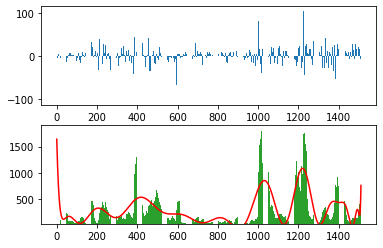

In [168]:
BarReturnsPlot(sp)

In [122]:
def ReturnsDistr(A,every_nth_day):    
    if len(A.shape) == 2:
        returns = A['Close'].iloc[2::every_nth_day].reset_index(drop=True)-A['Open'].iloc[1:-1:every_nth_day].reset_index(drop=True)
    else:
        returns = A
    print(returns.size)
    plt.hist(returns, bins=100, density = True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = norm.fit(returns)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()
    return jarque_bera(returns)

Here S&P 500 data is used:

1508


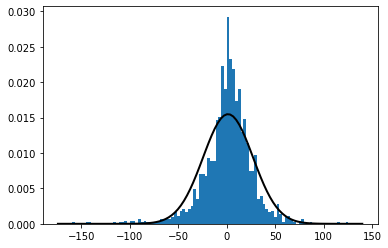

(1516.9495921720957, 0.0)

In [169]:
#Adjust size op your data to compare the effect of length of time periods, 
#i.e. JB from ReturnsDistr(sp[0:100],1) and ReturnsDistr(sp[0:1000],10) are comparable 
ReturnsDistr(sp,1)

In [241]:
def DayRealVol(df,n):
    dated = df[3:].reset_index(drop=True)
    #for i,elt in enumerate(dated['Unnamed: 0']):
        #if i %1000 == 0:
        #    print(i)
        #dated['Unnamed: 0'].iloc[i] = datetime.strptime(elt, '%Y-%m-%d %H:%M:%S')
    dated = dated.set_index('Unnamed: 0')
    DFList = [group[1] for group in dated.groupby(dated.index.date)]
    md = DFList[n]['A.3']
    #Processing data
    md = md.dropna().reset_index(drop=True).iloc[1:]
    for i in range(len(md)):
        md.iloc[i] = pd.to_numeric(md.iloc[i])
    returns = (md.shift(-1).iloc[:-1])/md.iloc[:-1]
    for i, elt in enumerate(returns):
        returns.iloc[i] = np.log(elt)
    #Start those calculationssss
    RealVol = 0
    for elt in returns:
        RealVol += elt**2
    return RealVol

def RollingRealVol(df):
    for i in range(0,):
        df[i] = RealVol(df[:i],M,i)
    return df

In [242]:
lin = np.linspace(1,113,113)
DRV = np.zeros(113)
for i, elt in enumerate(lin):
    print(elt)
    DRV[i] = DayRealVol(minute_data,i)*365
    print(DRV[i])
plt.plot(lin,DRV)

1.0
0.031050125804115876
2.0
0.026390865022595345
3.0
0.03128906200480233
4.0
0.02214964993031181
5.0
0.031084806793902187
6.0
0.019466285304238187
7.0
0.013993977512128398
8.0
0.02913897922291344
9.0
0.02032112381263704
10.0
0.016889980990074216
11.0
0.04883549525569895
12.0
0.02867518777239857
13.0
0.024289856027255047
14.0
0.025704876870342442
15.0
0.021287931654546965
16.0
0.033255221168821784
17.0
0.03105429186483287
18.0
0.029914407743047603
19.0
0.014958607617019162
20.0
0.01765349553437878
21.0
0.02650763626718326
22.0
0.021262435290420656
23.0
0.015946054769412486
24.0
0.03040133532010998
25.0
0.023470475016953218
26.0
0.02213440467330736
27.0
0.021200744539890404
28.0
0.01646720255861878
29.0
0.023549975170689203
30.0
0.019362578301389332
31.0
0.030296957542290677
32.0
0.03642262675170266
33.0
0.037323834083311226
34.0
0.021801524341480766
35.0
0.03949165295339042
36.0
0.0252885796860745
37.0
0.023568510637036296
38.0
0.019362295897779803
39.0
0.02188568674144083
40.0
0.02248

IndexError: list index out of range

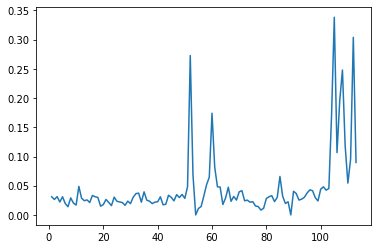

In [246]:
DRV = DRV[:113]
lin = lin[:113]
plt.plot(lin,DRV)

In [93]:
md = minute_data['A.3'].dropna().reset_index(drop=True).iloc[1:]
for i in range(len(md)):
    md.iloc[i] = pd.to_numeric(md.iloc[i])
returns = (md.shift(-1).iloc[:-1])/md.iloc[:-1]
for i, elt in enumerate(returns):
    returns.iloc[i] = np.log(elt)

1         0.00305064
2        0.000456795
3          0.0028882
4       -0.000759244
5        -0.00258575
            ...     
41536    0.000416031
41537   -0.000762856
41538   -0.000138764
41539   -0.000694107
41540   -0.000569528
Name: A.3, Length: 41540, dtype: object


In [115]:
DayRealVol(returns,2)*365

0.032554430222052726

In [194]:
minute_data = lo
display(sp)
RollingRealVol(sp['Close'],10000)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-02-14,1828.459961,1841.650024,1825.589966,0.000000,1838.630005,3114750000
1,2014-02-18,1839.030029,1842.869995,1835.010010,1840.760010,1840.760010,3421110000
2,2014-02-19,1838.900024,1847.500000,1826.989990,1828.750000,1828.750000,3661570000
3,2014-02-20,1829.239990,1842.790039,1824.579956,1839.780029,1839.780029,3404980000
4,2014-02-21,1841.069946,1846.130005,1835.599976,1836.250000,1836.250000,3403880000
...,...,...,...,...,...,...,...
1505,2020-02-07,3335.540039,3341.419922,3322.120117,3327.709961,3327.709961,3730650000
1506,2020-02-10,3318.280029,3352.260010,3317.770020,3352.090088,3352.090088,3450350000
1507,2020-02-11,3365.870117,3375.629883,3352.719971,3357.750000,3357.750000,3760550000
1508,2020-02-12,3370.500000,3381.469971,3369.719971,3379.449951,3379.449951,3926380000


C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Max J. de Bock\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyError: -1